In [ ]:
!pip install catboost
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [ ]:
dataweather = pd.read_excel('погода.xls')
dataweather

,Местное время в Москве (ВДНХ),T_М,W1_М,T_С,W1_С,T_К,W1_К
0,21.09.2024 15:00,21.9,NaN,22.0,Ливень (ливни).,27.1,NaN
1,21.09.2024 12:00,19.6,NaN,19.2,Ливень (ливни).,24.0,NaN
2,21.09.2024 09:00,15.1,NaN,16.5,Ливень (ливни).,20.3,NaN
3,21.09.2024 06:00,11.5,NaN,16.8,Ливень (ливни).,12.1,NaN
4,21.09.2024 03:00,14.6,NaN,17.7,Гроза (грозы) с осадками или без них.,14.2,NaN
...,...,...,...,...,...,...,...
7948,01.01.2022 12:00,-0.7,Облака покрывали более половины неба в течение...,9.1,Ливень (ливни).,NaN,NaN
7949,01.01.2022 09:00,-1.4,Снег или дождь со снегом.,6.1,Ливень (ливни).,NaN,NaN
7950,01.01.2022 06:00,-1.5,Снег или дождь со снегом.,6.7,Ливень (ливни).,NaN,NaN
7951,01.01.2022 03:00,-1.9,Снег или дождь со снегом.,7.7,Ливень (ливни).,NaN,NaN


In [ ]:
dataweather['date'] = pd.to_datetime(dataweather['Местное время в Москве (ВДНХ)'], format='%d.%m.%Y %H:%M')

result = dataweather.groupby(dataweather['date'].dt.date).agg(
    average_temperature_M=('T_М', 'mean'),
    first_weather_M=('W1_М', 'first'),
    average_temperature_K=('T_К', 'mean'),
    first_weather_K=('W1_К', 'first'),
    average_temperature_C=('T_С', 'mean'),
    first_weather_C=('W1_С', 'first')
).reset_index()

result['Year'] = result['date'].apply(lambda x: x.year)
result['month'] = result['date'].apply(lambda x: x.month)
result['day'] = result['date'].apply(lambda x: x.day)

result['first_weather_K'] = result['first_weather_K'].fillna('Хорошая погода')
result['first_weather_M'] = result['first_weather_M'].fillna('Хорошая погода')
result['first_weather_C'] = result['first_weather_M'].fillna('Хорошая погода')
result = result.drop(columns=['date'])
print("Столбцы в dataweather:", result.columns)
result.to_csv("Погода.csv")
result.info()

Столбцы в dataweather: Index(['average_temperature_M', 'first_weather_M', 'average_temperature_K',
       'first_weather_K', 'average_temperature_C', 'first_weather_C', 'Year',
       'month', 'day'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 995 entries, 0 to 994
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   average_temperature_M  995 non-null    float64
 1   first_weather_M        995 non-null    object 
 2   average_temperature_K  995 non-null    float64
 3   first_weather_K        995 non-null    object 
 4   average_temperature_C  995 non-null    float64
 5   first_weather_C        995 non-null    object 
 6   Year                   995 non-null    int64  
 7   month                  995 non-null    int64  
 8   day                    995 non-null    int64  
dtypes: float64(3), int64(3), object(3)
memory usage: 70.1+ KB


In [ ]:
dataInfl = pd.read_excel('Инфляция и ключевая ставка Банка России_F01_01_2022_T31_12_2023.xlsx')

In [ ]:
dataInfl

,Год,Месяц,Ключевая ставка,Инфляция
0,2023,12,16.0,7.42
1,2023,11,15.0,7.48
2,2023,10,15.0,6.69
3,2023,9,13.0,6.00
4,2023,8,12.0,5.15
5,2023,7,8.5,4.30
6,2023,6,7.5,3.25
7,2023,5,7.5,2.51
8,2023,4,7.5,2.31
9,2023,3,7.5,3.51


In [ ]:
data = pd.read_excel('data.xlsx')

In [ ]:
data = pd.read_excel('test.xlsx')

KeyboardInterrupt: 

In [ ]:
from sklearn.preprocessing import LabelEncoder
def encode_columns(df):
    le = LabelEncoder()
    for column in data.select_dtypes(include=['object']).columns:
        df[column] = le.fit_transform(df[column])
    return df
data = encode_columns(data)
data

,Номеров,Стоимость,Внесена предоплата,Способ оплаты,Дата бронирования,Заезд,Ночей,Выезд,Источник,Категория номера,Гостей,Гостиница,Target
0,1,25700.0,0,6,2023-04-20 20:37:30,2023-04-28 15:00:00,3,2023-05-01 12:00:00,26,25,2,1,1
1,1,24800.0,12400,11,2022-06-18 14:17:02,2022-07-11 15:00:00,2,2022-07-13 12:00:00,23,25,2,1,0
2,1,25800.0,12900,4,2022-11-14 22:59:30,2022-12-04 15:00:00,2,2022-12-06 12:00:00,23,27,2,4,0
3,1,10500.0,0,9,2023-09-08 15:55:53,2023-09-18 15:00:00,1,2023-09-19 12:00:00,9,25,1,3,0
4,1,28690.0,28690,13,2023-05-20 19:54:13,2023-05-29 15:00:00,2,2023-05-31 12:00:00,23,24,4,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
26169,1,18240.0,9120,4,2023-01-07 17:45:18,2023-03-10 15:00:00,2,2023-03-12 12:00:00,23,25,2,2,0
26170,1,69600.0,23200,4,2023-06-20 17:54:17,2023-06-25 15:00:00,3,2023-06-28 12:00:00,23,27,3,4,0
26171,1,55600.0,13900,4,2022-05-08 19:24:05,2022-06-24 15:00:00,4,2022-06-28 12:00:00,23,25,2,2,0
26172,1,6300.0,0,10,2022-02-19 09:55:50,2022-04-27 15:00:00,1,2022-04-28 12:00:00,17,25,2,3,1


In [ ]:
data['Дата бронирования'] = pd.to_datetime(data['Дата бронирования'])
data['year_Дата бронирования'] = data['Дата бронирования'].dt.year.astype('int64')
data['month_Дата бронирования'] = data['Дата бронирования'].dt.month.astype('int64')
data['day_Дата бронирования'] = data['Дата бронирования'].dt.day.astype('int64')
data['day_of_week_Дата бронирования'] = data['Дата бронирования'].dt.dayofweek.astype('int64')
data.drop('Дата бронирования', axis=1, inplace=True)
data['Заезд'] = pd.to_datetime(data['Заезд'])
data['month_Заезд'] = data['Заезд'].dt.month.astype('int64')
data['day_Заезд'] = data['Заезд'].dt.day.astype('int64')
data['day_of_week_Заезд'] = data['Заезд'].dt.dayofweek.astype('int64')
data.drop('Заезд', axis=1, inplace=True)
data.drop('Выезд', axis=1, inplace=True)


In [ ]:
def определить_сезон(month):
    if month == 12 or month < 3:
        return 1
    elif 2 < month < 6:
        return 2
    elif 5 < month < 9:
        return 3
    elif 8 < month < 12:
        return 4

data['Сезон'] = data['month_Заезд'].apply(определить_сезон)

data = data.merge(dataInfl, left_on=['month_Дата бронирования', 'year_Дата бронирования'],
                  right_on=['Месяц', 'Год'], how='left')
data.drop(['Год', 'Месяц'], axis=1, inplace=True)
data.head()
print("Столбцы в data:", data.columns)
# data = data.merge(dataweather, left_on=['year_Дата бронирования', 'month_Дата бронирования', 'day_Дата бронирования'],
#                   right_on=['Year', 'month', 'day'], how='left')

# data.drop(['Год1', 'Месяц1', 'year_Дата бронирования', 'День1'], axis=1, inplace=True)

data.head()

Столбцы в data: Index(['Номеров', 'Стоимость', 'Внесена предоплата', 'Способ оплаты', 'Ночей',
       'Источник', 'Категория номера', 'Гостей', 'Гостиница', 'Target',
       'year_Дата бронирования', 'month_Дата бронирования',
       'day_Дата бронирования', 'day_of_week_Дата бронирования', 'month_Заезд',
       'day_Заезд', 'day_of_week_Заезд', 'Сезон', 'Ключевая ставка',
       'Инфляция'],
      dtype='object')


,Номеров,Стоимость,Внесена предоплата,Способ оплаты,Ночей,Источник,Категория номера,Гостей,Гостиница,Target,year_Дата бронирования,month_Дата бронирования,day_Дата бронирования,day_of_week_Дата бронирования,month_Заезд,day_Заезд,day_of_week_Заезд,Сезон,Ключевая ставка,Инфляция
0,1,25700.0,0,Внешняя система оплаты,3,Яндекс.Путешествия,Номер «Стандарт»,2,1,1,2023,4,20,3,4,28,4,2,7.5,2.31
1,1,24800.0,12400,Отложенная электронная оплата: Банк Россия (ба...,2,Официальный сайт,Номер «Стандарт»,2,1,0,2022,6,18,5,7,11,0,3,9.5,15.90
2,1,25800.0,12900,Банк. карта: Банк Россия (банк. карта),2,Официальный сайт,Номер «Студия»,2,4,0,2022,11,14,0,12,4,6,1,7.5,11.98
3,1,10500.0,0,Внешняя система оплаты (С предоплатой),1,Bronevik.com(new),Номер «Стандарт»,1,3,0,2023,9,8,4,9,18,0,4,13.0,6.00
4,1,28690.0,28690,Система быстрых платежей: Эквайринг ComfortBoo...,2,Официальный сайт,Номер «Люкс»,4,1,0,2023,5,20,5,5,29,0,2,7.5,2.51


In [ ]:
y = data['Target']
data = data.drop('Target', axis=1)
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.7, random_state=42)

In [ ]:
from catboost import CatBoostClassifier
cat_features = ['Способ оплаты', 'Источник', 'Категория номера']

model = CatBoostClassifier(iterations=801, learning_rate=0.03428285642946706, depth=4, random_seed=42, cat_features=cat_features, verbose=100)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)

print(classification_report(y_test, y_pred))
print(f'ROC-AUC: {roc_auc_score(y_test, y_pred_proba[:, 1])}')

0:	learn: 0.6705594	total: 11ms	remaining: 8.77s
100:	learn: 0.3327717	total: 943ms	remaining: 6.54s
200:	learn: 0.3206148	total: 1.9s	remaining: 5.66s
300:	learn: 0.3124358	total: 2.82s	remaining: 4.68s
400:	learn: 0.3041867	total: 3.77s	remaining: 3.77s
500:	learn: 0.2961229	total: 4.72s	remaining: 2.83s
600:	learn: 0.2881077	total: 5.68s	remaining: 1.89s
700:	learn: 0.2811403	total: 7.79s	remaining: 1.11s
800:	learn: 0.2754235	total: 10.2s	remaining: 0us
              precision    recall  f1-score   support

           0       0.89      0.99      0.94     14710
           1       0.95      0.51      0.67      3612

    accuracy                           0.90     18322
   macro avg       0.92      0.75      0.80     18322
weighted avg       0.90      0.90      0.89     18322

ROC-AUC: 0.8360913146976654


In [ ]:
import optuna
from catboost import CatBoostClassifier

cat_features = ['Способ оплаты', 'Источник', 'Категория номера']

def objective(trial):
    # Подбор гиперпараметров
    iterations = trial.suggest_int('iterations', 500, 1500)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.4)
    depth = trial.suggest_int('depth', 4, 12)
    l2_leaf_reg = trial.suggest_int('l2_leaf_reg', 3, 15)
    random_strength = trial.suggest_int('random_strength', 1, 10)

    model = CatBoostClassifier(iterations=iterations,
                               learning_rate=learning_rate,
                               depth=depth,
                               random_seed=42,
                               cat_features=cat_features,
                               l2_leaf_reg = l2_leaf_reg,
                               random_strength=random_strength,
                               verbose=0)

    model.fit(X_train, y_train)
    y_pred_proba = model.predict_proba(X_test)

    # Оценка модели
    return roc_auc_score(y_test, y_pred_proba[:, 1])

# Запуск оптимизации
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Вывод наилучших гиперпараметров
print("Best hyperparameters: ", study.best_params)
print("Best AUC: ", study.best_value)


[I 2024-09-21 15:24:35,971] A new study created in memory with name: no-name-4fa9f815-88c7-4819-96d9-d3806b7ff550
[I 2024-09-21 15:24:42,979] Trial 0 finished with value: 0.8168037202075114 and parameters: {'iterations': 554, 'learning_rate': 0.34568753198713137, 'depth': 4, 'l2_leaf_reg': 12, 'random_strength': 5}. Best is trial 0 with value: 0.8168037202075114.
[I 2024-09-21 15:25:10,399] Trial 1 finished with value: 0.812049155583059 and parameters: {'iterations': 749, 'learning_rate': 0.3182676701747498, 'depth': 10, 'l2_leaf_reg': 4, 'random_strength': 2}. Best is trial 0 with value: 0.8168037202075114.
[I 2024-09-21 15:25:18,099] Trial 2 finished with value: 0.8170759640235397 and parameters: {'iterations': 538, 'learning_rate': 0.1558666023120334, 'depth': 7, 'l2_leaf_reg': 12, 'random_strength': 7}. Best is trial 2 with value: 0.8170759640235397.
[I 2024-09-21 15:25:52,328] Trial 3 finished with value: 0.8144757485622741 and parameters: {'iterations': 1136, 'learning_rate': 0.1

Best hyperparameters:  {'iterations': 936, 'learning_rate': 0.020712159893039355, 'depth': 7, 'l2_leaf_reg': 9, 'random_strength': 1}
Best AUC:  0.8359534989117775


In [ ]:
y_pred = model.predict(data)
y_pred_proba = model.predict_proba(data)
y_pred

array([0, 0, 0, ..., 0, 0, 0])

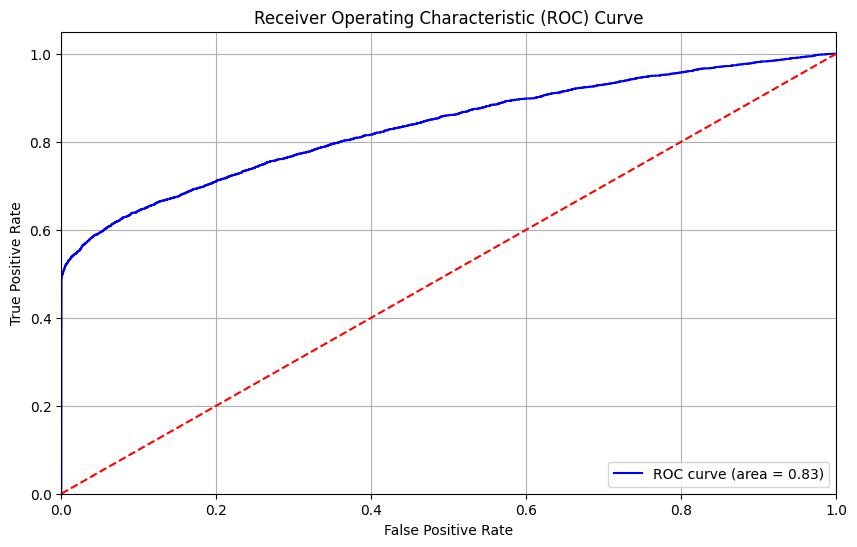

              precision    recall  f1-score   support

           0       0.89      1.00      0.94     14710
           1       0.98      0.51      0.67      3612

    accuracy                           0.90     18322
   macro avg       0.93      0.75      0.80     18322
weighted avg       0.91      0.90      0.89     18322

ROC-AUC: 0.8338231839935316


In [ ]:
if y_test.ndim == 2:
   y_test = y_test.flatten()
roc_auc = roc_auc_score(y_test, y_pred_proba[:, 1])
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:, 1])

# Построение ROC-кривой
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Линия случайного угадывания
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# Выводим отчёт
print(classification_report(y_test, y_pred))
print(f'ROC-AUC: {roc_auc}')